# Transformer Network Training

Author: Luna Lyu <br>
Date: 11/10/2024

## Import Packages

In [1]:
# system
import os
import pickle
import gzip

# data manipulation
import pandas as pd
import numpy as np

# deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
os.getcwd()

'/home/jianhaozheng/Downloads/test2'

## Import Dataset

In [3]:
with gzip.open('./gene_id_label_ohe (2).pkl.gz', 'rb') as f:
    data = pickle.load(f)

In [4]:
data

,ensembl_gene_id,DE,upstream_region_encoded
0,ENSG00000000457,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
1,ENSG00000000460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0,..."
2,ENSG00000000938,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [1,..."
3,ENSG00000000971,1,"[[0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,..."
4,ENSG00000001460,0,"[[0, 0, 0, 1], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."
...,...,...,...
55221,ENSG00000284520,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 1, 0, 0], [1,..."
55222,ENSG00000284544,0,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,..."
55223,ENSG00000284554,0,"[[1, 0, 0, 0], [0, 0, 1, 0], [1, 0, 0, 0], [0,..."
55224,ENSG00000284568,0,"[[1, 0, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,..."


## Quality Control

In [5]:
X = np.stack(data['upstream_region_encoded'].values)
Y = data['DE'].values

In [6]:
print(X.shape)
print(Y.shape)

(55223, 2000, 4)
(55223,)


In [7]:
print(type(X))
print(type(Y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


## Train-test Split

In [8]:
X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=123)

In [9]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(44178, 2000, 4)
(11045, 2000, 4)
(44178,)
(11045,)


We need to add one more channel to train CNN.

In [10]:
X_train = np.expand_dims(X_train, axis=-1)
X_dev = np.expand_dims(X_dev, axis=-1) 

In [11]:
print(X_train.shape)
print(X_dev.shape)
print(Y_train.shape)
print(Y_dev.shape)

(44178, 2000, 4, 1)
(11045, 2000, 4, 1)
(44178,)
(11045,)


Hyperparameters:

In [12]:
BATCH_SIZE = 256
EPOCH_SIZE = 5
LEARNING_RATE = 1e-3

Shuffle the dataset and apply mini-batch gradient descent with a batch size of 256:

In [13]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = TensorDataset(torch.FloatTensor(X_dev), torch.FloatTensor(Y_dev))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
class DNATransformer(nn.Module):
    def __init__(self, 
                 d_model=128,
                 nhead=8,
                 num_layers=3,
                 dim_feedforward=256,
                 dropout=0.1,
                 num_classes=2):
        super(DNATransformer, self).__init__()
        
        self.embedding = nn.Linear(4, d_model)
        self.pos_encoder = nn.Parameter(torch.randn(1, 2000, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)  # directly ouput logits
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = x + self.pos_encoder
        x = self.transformer(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)  # Returns logits
        return x

def train_and_evaluate(model, train_loader, val_loader, num_epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long()
            
            if inputs.shape[-1] == 1:
                inputs = inputs.squeeze(-1)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            predicted = outputs.argmax(dim=1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        scheduler.step()
        
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total
        
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).long()  # Convert to long
                
                if inputs.shape[-1] == 1:
                    inputs = inputs.squeeze(-1)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                predicted = outputs.argmax(dim=1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print('-' * 50)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return history

Using device: cuda
Epoch 1/5:
Train Loss: 0.2766, Train Acc: 91.92%
Val Loss: 0.2607, Val Acc: 92.90%
--------------------------------------------------
Epoch 2/5:
Train Loss: 0.2709, Train Acc: 92.44%
Val Loss: 0.2614, Val Acc: 92.90%
--------------------------------------------------
Epoch 3/5:
Train Loss: 0.2696, Train Acc: 92.44%
Val Loss: 0.2584, Val Acc: 92.90%
--------------------------------------------------
Epoch 4/5:
Train Loss: 0.2662, Train Acc: 92.44%
Val Loss: 0.2565, Val Acc: 92.90%
--------------------------------------------------
Epoch 5/5:
Train Loss: 0.2657, Train Acc: 92.44%
Val Loss: 0.2536, Val Acc: 92.90%
--------------------------------------------------


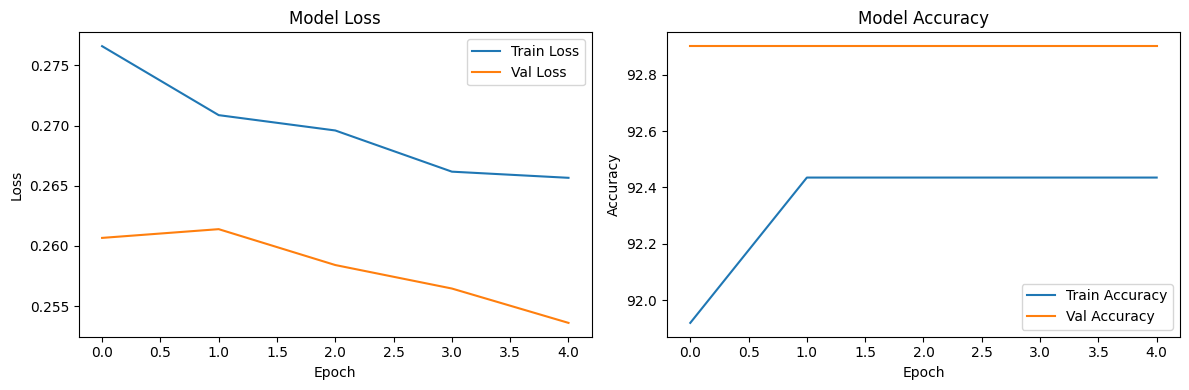

In [15]:
model = DNATransformer()
history = train_and_evaluate(model, train_loader, val_loader, num_epochs=EPOCH_SIZE)

In [16]:
history

{'train_loss': [0.27660429537985365,
  0.27087222177513764,
  0.26959767550057756,
  0.2661747957412907,
  0.2656635020165085],
 'train_acc': [91.91905473312508,
  92.43514871655576,
  92.43514871655576,
  92.43514871655576,
  92.43514871655576],
 'val_loss': [0.2606705030934377,
  0.26139640706506645,
  0.25841478698632936,
  0.25646214999935846,
  0.25360713628205384],
 'val_acc': [92.90176550475329,
  92.90176550475329,
  92.90176550475329,
  92.90176550475329,
  92.90176550475329]}